In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 2 [20 points]  
● Download the MNIST dataset. It’s available in many places, including  Kaggle   
● Create a modified training set  
   * For each image in the train set, generate two images where the probability of a pixel value being flipped is 0.03
   * Your new training set size should be 120K
   
● Review the blog on keras and autoencoders,
https://blog.keras.io/building-autoencoders-in-keras.html  
● Implement a convolutional autoencoder (four times)  
 * Vary the CNN architecture in four ways  
 * Optimize as best as possible during training 
 
● Plot the test set error (mean L2 error) as a function of the number of samples  used to train each autoencoder    
● Plot the best- and worst set of digits as measured by error (original image,reconstructed image)  

### Preprocess data

In [4]:
from keras.datasets import mnist
(x_train, _), (x_test, test_label) = mnist.load_data()

In [5]:
#load the mnist data 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


In [6]:
#create training set with flipped pixels
x_train_2 = np.empty([120000,784], dtype = 'float32')
x_train_clean = np.empty([120000,784], dtype = 'float32')

In [7]:
index_1 = 0
index_2 = 1
for row in x_train:
    #flip the pixels by randomly drawing pixels with probability of 0.03
    flipped_index_1 = np.random.choice(784, int(784*0.03),replace = False)
    flipped_row_1 = row.copy()
    for pix in flipped_index_1:
        flipped_row_1[pix] = 1- flipped_row_1[pix]
        
    flipped_index_2 = np.random.choice(784, int(784*0.03),replace = False)
    flipped_row_2 = row.copy()
    for pix in flipped_index_2:
        flipped_row_2[pix] = 1- flipped_row_2[pix]
    
    x_train_2[index_1,:] = flipped_row_1
    x_train_2[index_2,:] = flipped_row_2
    
    x_train_clean[index_1,:] = row
    x_train_clean[index_2,:] = row
    
    index_1 +=2
    index_2 +=2

In [8]:
#the training set consists of 120K samples
#the one with noise
x_train_2 = np.reshape(x_train_2, (len(x_train_2), 28, 28, 1))
#the one is clean
x_train_clean = np.reshape(x_train_clean, (len(x_train_clean), 28, 28, 1))
#test set
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

In [18]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.losses import mean_squared_error
from keras.callbacks import TensorBoard,History

#helper functions to print out digits
def plot_digits(decoded_imgs, x_test, index):

    x_test_sub = x_test[index]
    decoded_imgs_sub = decoded_imgs[index]
    n= len(x_test_sub)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_sub[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs_sub[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#helper functions to print out index for best/worst set
def get_best_worst_digits(decoded_imgs, x_test):
    x_test_data = x_test.reshape(len(x_test), 784)
    decoded_imgs_data = decoded_imgs.reshape(len(decoded_imgs), 784)
    mse_list = []
    for i in xrange(x_test_data.shape[0]):
        mse = np.sum(np.square(x_test_data[i,:] - decoded_imgs_data[i,:]))/784
        mse_list.append((i,mse))
    mse_list_sort= sorted(mse_list, key = lambda x: x[1])
    index = [index for (index,_) in mse_list_sort]
    top_10 = index[:10]
    bottom_10 = index[-10:]
    return top_10, bottom_10
        
#helper functions to print out rmse per epoch
def plot_mse(history):
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('mse per epoch')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.show()

### Running four different models
First model

In [10]:
#default model (very similar to the one in the blog)
input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])

In [11]:
history_model1 = autoencoder.fit(x_train_2,x_train_clean,epochs=10, batch_size = 64, shuffle=True,
                validation_data=(x_test, x_test))

Train on 120000 samples, validate on 10000 samples
Epoch 1/10
120000/120000 [==============================] - 264s - loss: 0.1810 - mean_squared_error: 0.0401 - val_loss: 0.1405 - val_mean_squared_error: 0.0263
Epoch 2/10
120000/120000 [==============================] - 252s - loss: 0.1369 - mean_squared_error: 0.0251 - val_loss: 0.1274 - val_mean_squared_error: 0.0219
Epoch 3/10
120000/120000 [==============================] - 248s - loss: 0.1286 - mean_squared_error: 0.0222 - val_loss: 0.1236 - val_mean_squared_error: 0.0205
Epoch 4/10
120000/120000 [==============================] - 246s - loss: 0.1239 - mean_squared_error: 0.0206 - val_loss: 0.1209 - val_mean_squared_error: 0.0196
Epoch 5/10
120000/120000 [==============================] - 246s - loss: 0.1205 - mean_squared_error: 0.0194 - val_loss: 0.1156 - val_mean_squared_error: 0.0178
Epoch 6/10
120000/120000 [==============================] - 231s - loss: 0.1181 - mean_squared_error: 0.0186 - val_loss: 0.1174 - val_mean_squar

In [12]:
decoded_imgs = autoencoder.predict(x_test)

Top digits with least mse


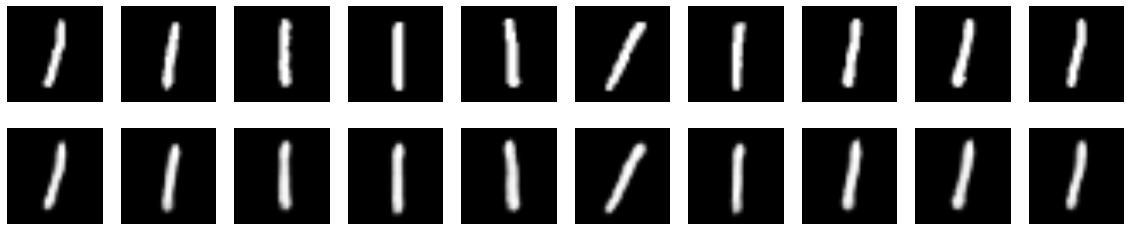

Bottom digits with most mse


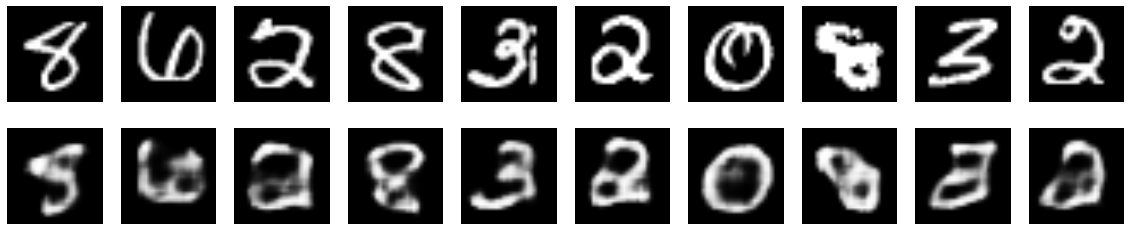

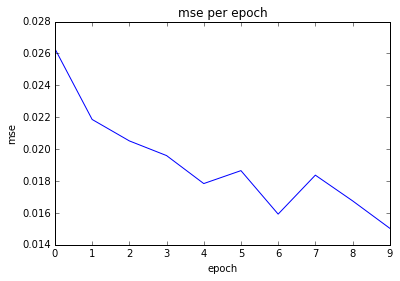

In [19]:
top10,bottom10 = get_best_worst_digits(decoded_imgs, x_test)
print "Top digits with least mse"
plot_digits(decoded_imgs,x_test, top10)
print "Bottom digits with most mse"
plot_digits(decoded_imgs,x_test, bottom10)
plot_mse(history_model1)

Second Model

In [20]:
#model 2 only 2 conv-layer each side, using 4*4 max pooling in the middle
x_1 = Conv2D(8, (2, 2), activation='relu', padding='same')(input_img)
x_1 = MaxPooling2D((4, 4), padding='same')(x_1)
x_1 = Conv2D(8, (2, 2), activation='relu', padding='same')(x_1)
encoded= MaxPooling2D((2, 2), padding='same')(x_1)

x_1 = Conv2D(8, (2, 2), activation='relu', padding='same')(encoded)
x_1 = UpSampling2D((2, 2))(x_1)
x_1 = Conv2D(8, (2, 2), activation='relu')(x_1)
x_1 = UpSampling2D((4, 4))(x_1)
decoded = Conv2D(1, (2, 2), activation='sigmoid',padding = 'same')(x_1)

autoencoder_2 = Model(input_img, decoded)
autoencoder_2.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])

In [21]:
History_model2 = autoencoder_2.fit(x_train_2,x_train_clean,epochs=10, batch_size = 64, shuffle=True,
                validation_data=(x_test, x_test))

Train on 120000 samples, validate on 10000 samples
Epoch 1/10
120000/120000 [==============================] - 73s - loss: 0.2649 - mean_squared_error: 0.0664 - val_loss: 0.2307 - val_mean_squared_error: 0.0571
Epoch 2/10
120000/120000 [==============================] - 67s - loss: 0.2259 - mean_squared_error: 0.0551 - val_loss: 0.2154 - val_mean_squared_error: 0.0524
Epoch 3/10
120000/120000 [==============================] - 67s - loss: 0.2143 - mean_squared_error: 0.0515 - val_loss: 0.2075 - val_mean_squared_error: 0.0498
Epoch 4/10
120000/120000 [==============================] - 66s - loss: 0.2091 - mean_squared_error: 0.0497 - val_loss: 0.2044 - val_mean_squared_error: 0.0487
Epoch 5/10
120000/120000 [==============================] - 67s - loss: 0.2061 - mean_squared_error: 0.0487 - val_loss: 0.2013 - val_mean_squared_error: 0.0476
Epoch 6/10
120000/120000 [==============================] - 67s - loss: 0.2043 - mean_squared_error: 0.0481 - val_loss: 0.2017 - val_mean_squared_err

In [30]:
decoded_imgs = autoencoder_2.predict(x_test)

Top digits with least mse


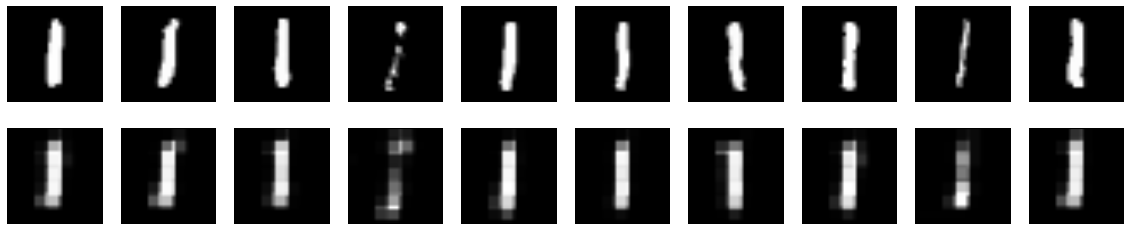

Bottom digits with most mse


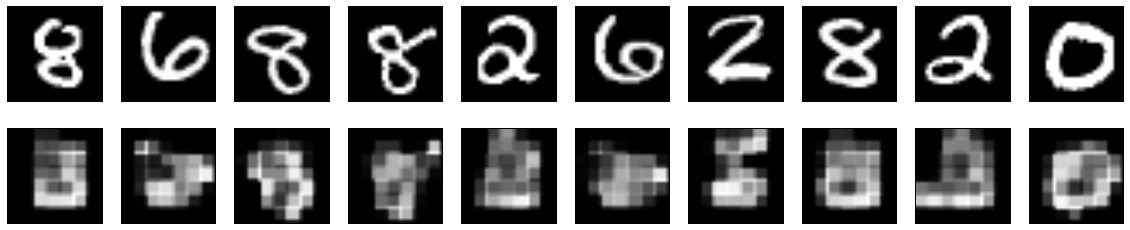

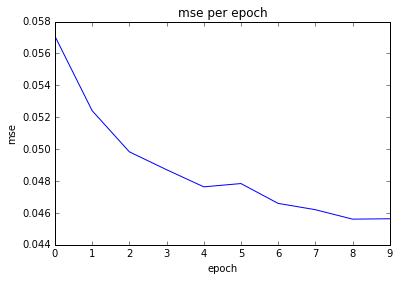

In [33]:
top10,bottom10 = get_best_worst_digits(decoded_imgs, x_test)
print "Top digits with least mse"
plot_digits(decoded_imgs,x_test, top10)
print "Bottom digits with most mse"
plot_digits(decoded_imgs,x_test, bottom10)
plot_mse(History_model2)

Third Model

In [23]:
#model 3 adding one additional layers after the inital conv-layer in both encoder and decoder
input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu',padding = 'same')(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_3 = Model(input_img, decoded)
autoencoder_3.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['mse'])

In [24]:
History_model3 = autoencoder_3.fit(x_train_2,x_train_clean,epochs=10, batch_size = 64, shuffle=True,
                validation_data=(x_test, x_test))

Train on 120000 samples, validate on 10000 samples
Epoch 1/10
120000/120000 [==============================] - 233s - loss: 0.1716 - mean_squared_error: 0.0370 - val_loss: 0.1355 - val_mean_squared_error: 0.0249
Epoch 2/10
120000/120000 [==============================] - 232s - loss: 0.1364 - mean_squared_error: 0.0248 - val_loss: 0.1261 - val_mean_squared_error: 0.0215
Epoch 3/10
120000/120000 [==============================] - 231s - loss: 0.1295 - mean_squared_error: 0.0224 - val_loss: 0.1237 - val_mean_squared_error: 0.0203
Epoch 4/10
120000/120000 [==============================] - 230s - loss: 0.1256 - mean_squared_error: 0.0210 - val_loss: 0.1244 - val_mean_squared_error: 0.0202
Epoch 5/10
120000/120000 [==============================] - 230s - loss: 0.1238 - mean_squared_error: 0.0204 - val_loss: 0.1260 - val_mean_squared_error: 0.0213
Epoch 6/10
120000/120000 [==============================] - 232s - loss: 0.1232 - mean_squared_error: 0.0202 - val_loss: 0.1146 - val_mean_squar

In [34]:
decoded_imgs = autoencoder_3.predict(x_test)

Top digits with least mse


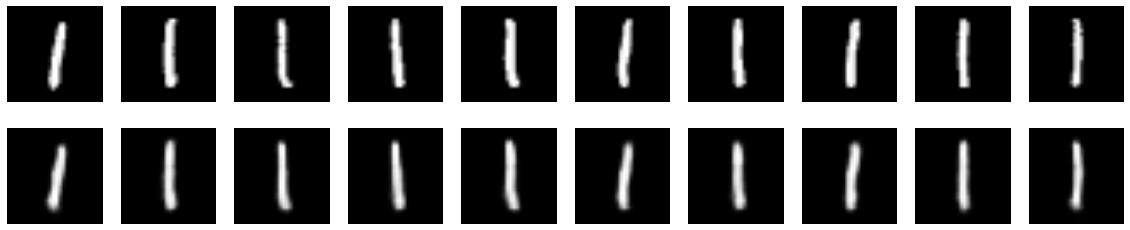

Bottom digits with most mse


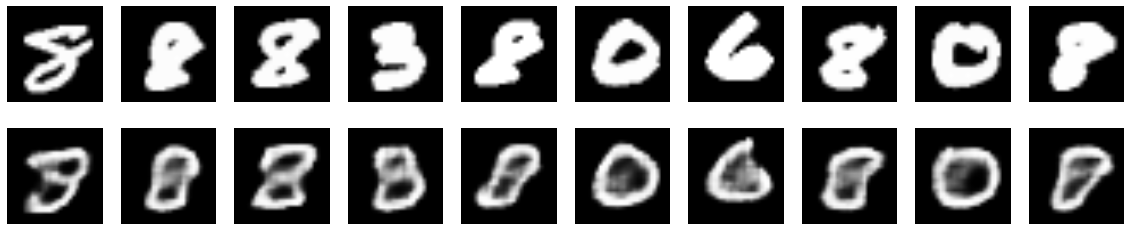

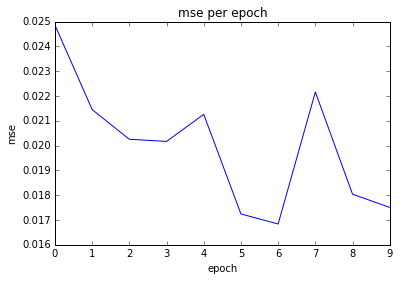

In [35]:
top10,bottom10 = get_best_worst_digits(decoded_imgs, x_test)
print "Top digits with least mse"
plot_digits(decoded_imgs,x_test, top10)
print "Bottom digits with most mse"
plot_digits(decoded_imgs,x_test, bottom10)
plot_mse(History_model3)

Forth Model

In [26]:
#model 4 with larger filter size
input_img = Input(shape=(28, 28, 1))

x = Conv2D(8, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (2, 2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (2, 2), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (4, 4), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

In [27]:
autoencoder_4 = Model(input_img, decoded)
autoencoder_4.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['mse'])

In [28]:
History_model4 = autoencoder_4.fit(x_train_2,x_train_clean,epochs=10, batch_size = 64, shuffle=True,
                validation_data=(x_test, x_test))

Train on 120000 samples, validate on 10000 samples
Epoch 1/10
120000/120000 [==============================] - 253s - loss: 0.1733 - mean_squared_error: 0.0373 - val_loss: 0.1334 - val_mean_squared_error: 0.0239
Epoch 2/10
120000/120000 [==============================] - 252s - loss: 0.1303 - mean_squared_error: 0.0228 - val_loss: 0.1188 - val_mean_squared_error: 0.0191
Epoch 3/10
120000/120000 [==============================] - 253s - loss: 0.1205 - mean_squared_error: 0.0194 - val_loss: 0.1173 - val_mean_squared_error: 0.0183
Epoch 4/10
120000/120000 [==============================] - 253s - loss: 0.1156 - mean_squared_error: 0.0178 - val_loss: 0.1098 - val_mean_squared_error: 0.0158
Epoch 5/10
120000/120000 [==============================] - 255s - loss: 0.1127 - mean_squared_error: 0.0168 - val_loss: 0.1059 - val_mean_squared_error: 0.0146
Epoch 6/10
120000/120000 [==============================] - 254s - loss: 0.1109 - mean_squared_error: 0.0162 - val_loss: 0.1077 - val_mean_squar

In [36]:
decoded_imgs = autoencoder_4.predict(x_test)

Top digits with least mse


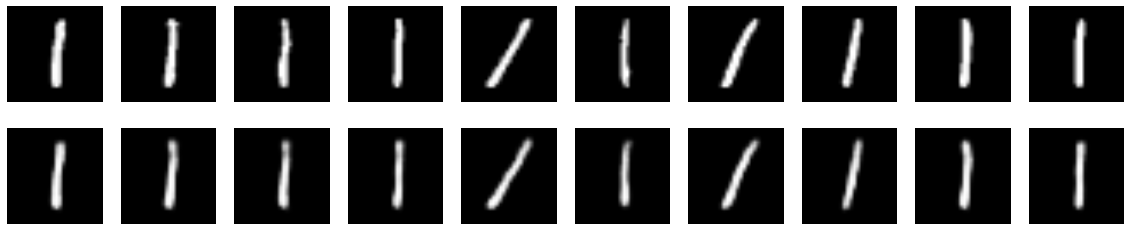

Bottom digits with most mse


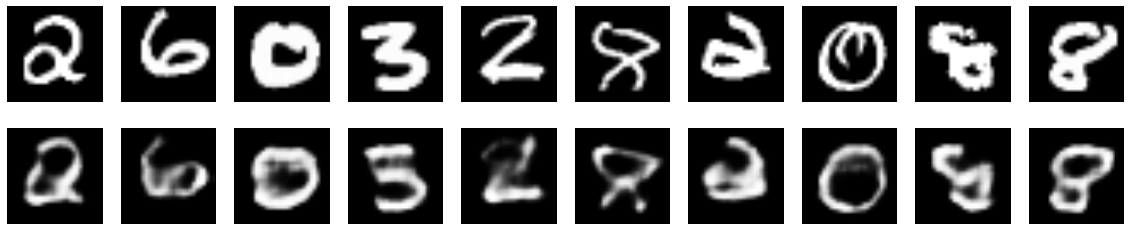

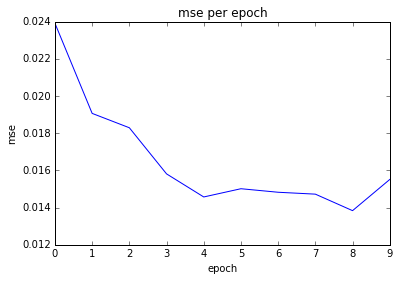

In [37]:
top10,bottom10 = get_best_worst_digits(decoded_imgs, x_test)
print "Top digits with least mse"
plot_digits(decoded_imgs,x_test, top10)
print "Bottom digits with most mse"
plot_digits(decoded_imgs,x_test, bottom10)
plot_mse(History_model4)